<a href="https://colab.research.google.com/github/ongtiongheng/rfml/blob/master/Different_attacks_PGD_FGSM_with_CLDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Upload dataset to Google drive i.e. RML2016a



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install the library code
!pip install --upgrade git+https://github.com/brysef/rfml.git
#extract to tmp folder only when not found
#![ ! -f "/tmp/RML2016.10a_dict.pkl" ] && tar -xf /content/drive/MyDrive/RML2016.10a.tar.bz2 -C /tmp
#check /tmp/ folder for dataset
#!ls -lah /tmp/RML*

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/brysef/rfml.git to /tmp/pip-req-build-batqwreu
  Running command git clone -q https://github.com/brysef/rfml.git /tmp/pip-req-build-batqwreu


## Install the library code and dependencies

In [ ]:
# Plotting Includes
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# External Includes
import numpy as np
from pprint import pprint

import torch
from torch.nn.functional import cross_entropy
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

# Internal Includes
from rfml.data import Dataset, Encoder
from rfml.data.converters import load_RML201610A_dataset

from rfml.nbutils import plot_acc_vs_snr, plot_confusion, plot_convergence, plot_IQ

from rfml.nn.eval import compute_accuracy, compute_accuracy_on_cross_sections, compute_confusion
from rfml.nn.model import Model
#CLDNN
from rfml.nn.layers import Flatten, PowerNormalization

#Attack Includes
from rfml.attack import fgsm, pgd
from rfml.nn.eval import compute_accuracy
from rfml.nn.eval.confusion import _confusion_matrix
from rfml.nn.F import energy
from rfml.data import build_dataset
from rfml.nn.model import build_model
from rfml.nn.train import build_trainer, PrintingTrainingListener
from rfml.nbutils import plot_acc_vs_spr, plot_confusion

from torch.utils.data import DataLoader

## Configuration

In [ ]:
gpu = True       # Set to True to use a GPU for training
fig_dir = None   # Set to a file path if you'd like to save the plots generated
data_path = "/content/drive/MyDrive/RML2016.10a_dict.pkl" # Set to a file path if you've downloaded RML2016.10A locally

## Loading a Dataset

The dataset used is downloaded from DeepSig Inc. and provided under a Creative Commons lic

In [ ]:
dataset = load_RML201610A_dataset(path=data_path)
print(len(dataset))
pprint(dataset.get_examples_per_class())

220000
{'8PSK': 20000,
 'AM-DSB': 20000,
 'AM-SSB': 20000,
 'BPSK': 20000,
 'CPFSK': 20000,
 'GFSK': 20000,
 'PAM4': 20000,
 'QAM16': 20000,
 'QAM64': 20000,
 'QPSK': 20000,
 'WBFM': 20000}


In [ ]:
train, test = dataset.split(frac=0.9, on=["Modulation", "SNR"])
train, val = train.split(frac=0.8, on=["Modulation", "SNR"])

print("Training Examples")
print("=================")
pprint(train.get_examples_per_class())
print("=================")
print()
print("Validation Examples")
print("=================")
pprint(val.get_examples_per_class())
print("=================")
print()
print("Testing Examples")
print("=================")
pprint(test.get_examples_per_class())
print("=================")

Training Examples
{'8PSK': 380,
 'AM-DSB': 380,
 'AM-SSB': 380,
 'BPSK': 380,
 'CPFSK': 380,
 'GFSK': 380,
 'PAM4': 380,
 'QAM16': 380,
 'QAM64': 380,
 'QPSK': 380,
 'WBFM': 380}

Validation Examples
{'8PSK': 1600,
 'AM-DSB': 1600,
 'AM-SSB': 1600,
 'BPSK': 1600,
 'CPFSK': 1600,
 'GFSK': 1600,
 'PAM4': 1600,
 'QAM16': 1600,
 'QAM64': 1600,
 'QPSK': 1600,
 'WBFM': 1600}

Testing Examples
{'8PSK': 18020,
 'AM-DSB': 18020,
 'AM-SSB': 18020,
 'BPSK': 18020,
 'CPFSK': 18020,
 'GFSK': 18020,
 'PAM4': 18020,
 'QAM16': 18020,
 'QAM64': 18020,
 'QPSK': 18020,
 'WBFM': 18020}


In [ ]:
le = Encoder(["WBFM",
              "AM-DSB",
              "AM-SSB",
              "CPFSK",
              "GFSK",
              "BPSK",
              "QPSK",
              "8PSK",
              "PAM4",
              "QAM16",
              "QAM64"],
             label_name="Modulation")
print(le)

WBFM: 0
AM-DSB: 1
AM-SSB: 2
CPFSK: 3
GFSK: 4
BPSK: 5
QPSK: 6
8PSK: 7
PAM4: 8
QAM16: 9
QAM64: 10



## Convolutional Long Deep Neural Network (CNN + GRU + MLP)

This network is based off of a network for modulation classification first
introduced in West/O'Shea.
The following modifications/interpretations were made by Bryse Flowers:

    - Batch Normalization was added otherwise the model was not stable enough to train
      in many cases (its unclear whether this was included in West's model)
    - The filter sizes were changed to 7 and the padding was set to 3 (where as
      West's paper said they used size 8 filters and did not mention padding)
        - An odd sized filter is necessary to ensure that the intermediate
          signal/feature map lengths are the same size and thus can be concatenated
          back together
    - A Gated Recurrent Unit (GRU) was used in place of a Long-Short Term Memory (LSTM).
        - These two submodules should behave nearly identically but GRU has one fewer
          equation
    - Bias was not used in the first convolution in order to more closely mimic the
      implementation of the CNN.
    - The hidden size of the GRU was set to be the number of classes it is trying to
      predict -- it makes the most sense instead of trying to find an arbritrary best
      hidden size.
    References
        N. E. West and T. O’Shea, “Deep architectures for modulation recognition,” in
        IEEE International Symposium on Dynamic Spectrum Access Networks (DySPAN), pp.
        1–6, IEEE, 2017.

In [ ]:
class MyCLDNN(Model):
    """Convolutional Long Deep Neural Network (CNN + GRU + MLP)
    This network is based off of a network for modulation classification first
    introduced in West/O'Shea.
    The following modifications/interpretations were made by Bryse Flowers:
    - Batch Normalization was added otherwise the model was not stable enough to train
      in many cases (its unclear whether this was included in West's model)
    - The filter sizes were changed to 7 and the padding was set to 3 (where as
      West's paper said they used size 8 filters and did not mention padding)
        - An odd sized filter is necessary to ensure that the intermediate
          signal/feature map lengths are the same size and thus can be concatenated
          back together
    - A Gated Recurrent Unit (GRU) was used in place of a Long-Short Term Memory (LSTM).
        - These two submodules should behave nearly identically but GRU has one fewer
          equation
    - Bias was not used in the first convolution in order to more closely mimic the
      implementation of the CNN.
    - The hidden size of the GRU was set to be the number of classes it is trying to
      predict -- it makes the most sense instead of trying to find an arbritrary best
      hidden size.
    References
        N. E. West and T. O’Shea, “Deep architectures for modulation recognition,” in
        IEEE International Symposium on Dynamic Spectrum Access Networks (DySPAN), pp.
        1–6, IEEE, 2017.
    """

    def __init__(self, input_samples: int, n_classes: int):
        super().__init__(input_samples, n_classes)

        # Batch x 1-channel x IQ x input_samples
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=50,
            kernel_size=(1, 7),
            padding=(0, 3),
            bias=False,
        )
        self.a1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(50)

        self.conv2 = nn.Conv2d(
            in_channels=50,
            out_channels=50,
            kernel_size=(1, 7),
            padding=(0, 3),
            bias=True,
        )
        self.a2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(50)

        self.conv3 = nn.Conv2d(
            in_channels=50,
            out_channels=50,
            kernel_size=(1, 7),
            padding=(0, 3),
            bias=True,
        )
        self.a3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(50)

        # Flatten along channels and I/Q
        self.flatten_preserve_time = Flatten(preserve_time=True)

        self.GRU_n_layers = 1
        self.GRU_n_directions = 1
        self.GRU_hidden_size = n_classes
        self.gru = nn.GRU(
            input_size=100 * 2,  # 100 channels after concatenation (50+50) * IQ (2)
            hidden_size=self.GRU_hidden_size,
            batch_first=True,
            num_layers=self.GRU_n_layers,
            bidirectional=False,
        )

        # Flatten everything outside of batch dimension
        self.flatten = Flatten()

        # Fully connected layers
        # All of the outputs of the GRU are taken (instead of just the final hidden
        # output after all of the time samples).  Therefore, the number of "features"
        # after flattening is the time length * the hidden size * number of directions
        self.dense1 = nn.Linear(
            input_samples * self.GRU_hidden_size * self.GRU_n_directions, 256
        )
        self.a4 = nn.ReLU()
        self.bn4 = nn.BatchNorm1d(256)

        self.dense2 = nn.Linear(256, n_classes)

    def forward(self, x):
        channel_dim = 1
        batch_size = x.shape[0]

        # Up front "filter" with no bias
        x = self.conv1(x)
        x = self.a1(x)
        a = self.bn1(x)  # Output is concatenated back as a "skip connection" below

        # Convolutional feature extraction layers
        x = self.conv2(a)
        x = self.a2(x)
        x = self.bn2(x)
        x = self.conv3(x)
        x = self.a3(x)
        x = self.bn3(x)

        # Concatenate the "skip connection" with the output of the rest of the CNN
        # pylint: disable=no-member
        x = torch.cat((a, x), dim=channel_dim)

        # Temporal feature extraction
        x = self.flatten_preserve_time(x)  # BxTxF
        hidden = x.new(
            self.GRU_n_layers * self.GRU_n_directions, batch_size, self.GRU_hidden_size
        )
        hidden.zero_()
        x, _ = self.gru(x, hidden)

        # MLP Classification stage
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.a4(x)
        x = self.bn4(x)

        x = self.dense2(x)

        return x

In [ ]:
model = MyCLDNN(input_samples=128, n_classes=11)
print(model)

MyCLDNN(
  (conv1): Conv2d(1, 50, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3), bias=False)
  (a1): ReLU()
  (bn1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(50, 50, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3))
  (a2): ReLU()
  (bn2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(50, 50, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3))
  (a3): ReLU()
  (bn3): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten_preserve_time): Flatten()
  (gru): GRU(200, 11, batch_first=True)
  (flatten): Flatten()
  (dense1): Linear(in_features=1408, out_features=256, bias=True)
  (a4): ReLU()
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense2): Linear(in_features=256, out_features=11, bias=True)
)
----------------------
Trainable Parameters: 406822
Fixed Parameters: 0
Total Parameters: 406822
---

## Implementing a Training Loop

In [ ]:
class MyTrainingStrategy(object):

    def __init__(self, lr: float = 10e-4, n_epochs: int = 4, gpu: bool = True):
        self.lr = lr
        self.n_epochs = n_epochs
        self.gpu = gpu

    def __repr__(self):
        ret = self.__class__.__name__
        ret += "(lr={}, n_epochs={}, gpu={})".format(self.lr, self.n_epochs, self.gpu)
        return ret
        
    def __call__(
        self, model: nn.Module, training: Dataset, validation: Dataset, le: Encoder
    ):
        criterion = nn.CrossEntropyLoss()

        if self.gpu:
            model.cuda()
            model.train()
            criterion.cuda()

        optimizer = Adam(model.parameters(), lr=self.lr)

        train_data = DataLoader(
            training.as_torch(le=le), shuffle=True, batch_size=512
        )
        val_data = DataLoader(
            validation.as_torch(le=le), shuffle=True, batch_size=512
        )

        # Save two lists for plotting a convergence graph at the end
        ret_train_loss = list()
        ret_val_loss = list()
        
        for epoch in range(self.n_epochs):
            train_loss = self._train_one_epoch(
                model=model, data=train_data, loss_fn=criterion, optimizer=optimizer
            )
            print("On Epoch {} the training loss was {}".format(epoch, train_loss))
            ret_train_loss.append(train_loss)

            val_loss = self._validate_once(
                model=model, data=val_data, loss_fn=criterion
            )
            print("---- validation loss was {}".format(val_loss))
            ret_val_loss.append(val_loss)

        return ret_train_loss, ret_val_loss

    def _train_one_epoch(
        self, model: nn.Module, data: DataLoader, loss_fn: nn.CrossEntropyLoss, optimizer: Adam
    ) -> float:
        total_loss = 0.0
        # Switch the model mode so it remembers gradients, induces dropout, etc.
        model.train()

        for i, batch in enumerate(data):
            x, y = batch

            # Push data to GPU if necessary
            if self.gpu:
                x = Variable(x.cuda())
                y = Variable(y.cuda())
            else:
                x = Variable(x)
                y = Variable(y)

            # Forward pass of prediction
            outputs = model(x)

            # Zero out the parameter gradients, because they are cumulative,
            # compute loss, compute gradients (backward), update weights
            loss = loss_fn(outputs, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        mean_loss = total_loss / (i + 1.0)
        return mean_loss

    def _validate_once(
        self, model: nn.Module, data: DataLoader, loss_fn: nn.CrossEntropyLoss
    ) -> float:
        total_loss = 0.0
        # Switch the model back to test mode (so that batch norm/dropout doesn't
        # take effect)
        model.train()
        for i, batch in enumerate(data):
            x, y = batch

            if self.gpu:
                x = x.cuda()
                y = y.cuda()

            outputs = model(x)
            loss = loss_fn(outputs, y)
            total_loss += loss.item()

        mean_loss = total_loss / (i + 1.0)
        return mean_loss

In [ ]:
trainer = MyTrainingStrategy(gpu=gpu)
print(trainer)

MyTrainingStrategy(lr=0.001, n_epochs=4, gpu=True)


## Putting it All Together

swap train and test

In [ ]:
xtrain = train
xtest = test
train = xtest
test = train

In [ ]:
train_loss, val_loss = trainer(model=model,
                               training=train,
                               validation=val,
                               le=le)

On Epoch 0 the training loss was 1.3075510272660207
---- validation loss was 1.197955788884844
On Epoch 1 the training loss was 1.166940169543335
---- validation loss was 1.1634766374315535
On Epoch 2 the training loss was 1.1354205829581034
---- validation loss was 1.1630192007337297
On Epoch 3 the training loss was 1.1123489365749752
---- validation loss was 1.1577170848846436


## Testing the Trained Model

In [ ]:
type(test)

rfml.data.dataset.Dataset

In [ ]:
spr = 6 # Signal to Pertubation raito in dB
torch.backends.cudnn.enabled = False

declaration

In [ ]:
def fgsm(x, y, input_size, net, spr, sps):
    p = compute_signed_gradient(x=x, y=y, input_size=input_size, net=net)
    p = scale_perturbation(sg=p, spr=spr, sps=sps)
    
    return x + p


def compute_signed_gradient(x, y, input_size, net):
    # Ensure that the gradient is tracked at the input, add some noise to avoid any
    # actual zeros in the signal (dithering), and then ensure its the proper shape
    x.requires_grad = True
    _x = _dither(x)

    # Put the inputs/outputs onto the most probable device that the model is currently
    # on -- this could fail if the model gets split amongst multiple devies, but, that
    # doesn't happen in this code.
    _x = _x.to(net.device)
    y = y.to(net.device)

    # Perform forward/backward pass to get the gradient at the input
    _y = net(_x)
    loss = cross_entropy(_y, y)
    loss.backward()

    # Take the sign of the gradient that can be scaled later
    ret = torch.sign(x.grad.data)

    return ret


def scale_perturbation(sg, spr, sps):
    if spr == np.inf:
        return sg * 0
    multiplier = pow(10, -spr / 10.0)
    multiplier = multiplier / (2 * sps)
    multiplier = pow(multiplier, 0.5)

    return sg * multiplier


def _dither(x):
    snr = 100
    voltage = pow(pow(10.0, -snr / 10.0), 0.5)

    noise = x.data.new(x.size()).normal_(0.0, voltage)
    return x + noise


def _normalize(x):
    power = energy(x)
    # Make the dimensions match because broadcasting is too magical to
    # understand in its entirety... essentially want to ensure that we
    # divide each channel of each example by the sqrt of the power of
    # that channel/example pair
    power = power.view([power.size()[0], power.size()[1], 1, 1])

    return x / torch.sqrt(power)


def _sanity_check(desired_spr, adv_x, x):
    signal_power = energy(x) # Google Colab always return 1 unit of energy ?
    perturbation_power = energy(adv_x - x) # Google Colab always return 5 units of perturbation when SPR is 6
    _spr = 10*torch.log10(signal_power / perturbation_power)
    _spr = _spr.detach().numpy().mean()
    if np.abs(_spr - desired_spr) > 0.4:
        raise RuntimeError("Calculated SPR and desired SPR does not match: "
                           "Desired SPR={:0.2f}dB, Calculated SPR={:0.2f}dB, "
                           "Signal Power={:0.2f}dB, Perturbation Power={:0.2f}dB".format(
                               desired_spr,
                               _spr,
                               10.0*np.log10(signal_power.detach().numpy().mean()),
                               10.0*np.log10(perturbation_power.detach().numpy().mean()))
                          )

swap back coz large train dataset too slow for attack

In [ ]:
# xtrain = train
# xtest = test
# train = xtest
# test = train

need fresh dataset for another FGSM attack

Strip Down the Testing Data
Strip the data down to only the highest SNR (18 dB in RML2016.10a). This ensures that the classification accuracy would have been close to the highest and gives the best evaluation of the attack because it separates the decreased accuracy from being causes by low SNR vs being caused by the attack.

Attack 1 - 1 DB

In [ ]:
mask = test.df["SNR"] >= 0
dl = DataLoader(test.as_torch(le=le, mask=mask), shuffle=True, batch_size=512)
spr = 1  # Signal to Pertubation raito in dB

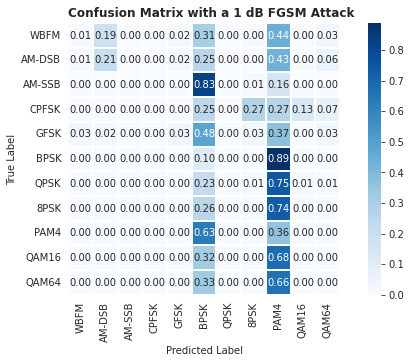

In [ ]:
predictions = list()
labels = list()
for x, y in dl:
    # Before crafting an attack on X, ensure that it is normalized to have a
    # specified power -- RML2016.10a fluctuates a bit, especially on AM-SSB,
    # which will cause the attack intensity to be incorrect.
    x = _normalize(x)
    adv_x = fgsm(x, y, spr=spr, input_size=128, sps=8, net=model)

    # Ensure that we've accurately represented the attack power
    #_sanity_check(desired_spr=spr, adv_x=adv_x, x=x)

    _predictions = model.predict(adv_x)
    predictions.extend(_predictions.detach().numpy())
    labels.extend(y)

cmn = _confusion_matrix(predictions=predictions, labels=labels, le=le)

title = "Confusion Matrix with a {spr} dB FGSM Attack".format(spr=spr)
fig = plot_confusion(cm=cmn, labels=le.labels, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/fgsm_confusion_matrix.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

Attack 2 - 4 DB

In [ ]:
mask = test.df["SNR"] >= 0
dl = DataLoader(test.as_torch(le=le, mask=mask), shuffle=True, batch_size=512)
spr = 4  # Signal to Pertubation raito in dB

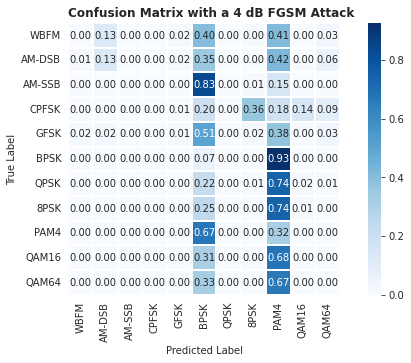

In [ ]:
predictions = list()
labels = list()
for x, y in dl:
    # Before crafting an attack on X, ensure that it is normalized to have a
    # specified power -- RML2016.10a fluctuates a bit, especially on AM-SSB,
    # which will cause the attack intensity to be incorrect.
    x = _normalize(x)
    adv_x = fgsm(x, y, spr=spr, input_size=128, sps=8, net=model)

    # Ensure that we've accurately represented the attack power
    #_sanity_check(desired_spr=spr, adv_x=adv_x, x=x)

    _predictions = model.predict(adv_x)
    predictions.extend(_predictions.detach().numpy())
    labels.extend(y)

cmn = _confusion_matrix(predictions=predictions, labels=labels, le=le)

title = "Confusion Matrix with a {spr} dB FGSM Attack".format(spr=spr)
fig = plot_confusion(cm=cmn, labels=le.labels, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/fgsm_confusion_matrix.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

Attack 3 - 8 DB

In [ ]:
spr = 8  # dB # Signal to Perturbation Ratio in DB, typically Sample to Signal size is set to 8

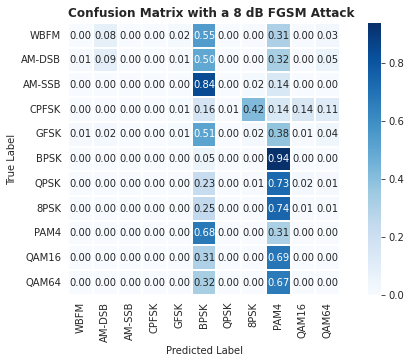

In [ ]:
predictions = list()
labels = list()
for x, y in dl:
    # Before crafting an attack on X, ensure that it is normalized to have a
    # specified power -- RML2016.10a fluctuates a bit, especially on AM-SSB,
    # which will cause the attack intensity to be incorrect.
    x = _normalize(x)
    adv_x = fgsm(x, y, spr=spr, input_size=128, sps=8, net=model)

    # Ensure that we've accurately represented the attack power
    #_sanity_check(desired_spr=spr, adv_x=adv_x, x=x)

    _predictions = model.predict(adv_x)
    predictions.extend(_predictions.detach().numpy())
    labels.extend(y)

cmn = _confusion_matrix(predictions=predictions, labels=labels, le=le)

title = "Confusion Matrix with a {spr} dB FGSM Attack".format(spr=spr)
fig = plot_confusion(cm=cmn, labels=le.labels, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/fgsm_confusion_matrix.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

Attack 4 - 12 DB

In [ ]:
spr = 12  # dB # Signal to Perturbation Ratio in DB, typically Sample to Signal size is set to 8

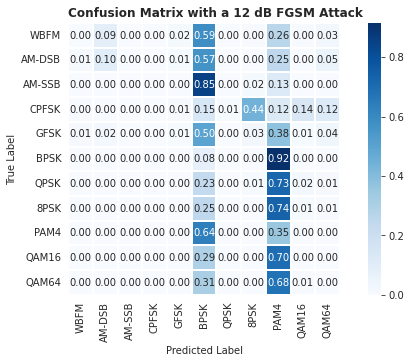

In [ ]:
predictions = list()
labels = list()
for x, y in dl:
    # Before crafting an attack on X, ensure that it is normalized to have a
    # specified power -- RML2016.10a fluctuates a bit, especially on AM-SSB,
    # which will cause the attack intensity to be incorrect.
    x = _normalize(x)
    adv_x = fgsm(x, y, spr=spr, input_size=128, sps=8, net=model)

    # Ensure that we've accurately represented the attack power
    #_sanity_check(desired_spr=spr, adv_x=adv_x, x=x)

    _predictions = model.predict(adv_x)
    predictions.extend(_predictions.detach().numpy())
    labels.extend(y)

cmn = _confusion_matrix(predictions=predictions, labels=labels, le=le)

title = "Confusion Matrix with a {spr} dB FGSM Attack".format(spr=spr)
fig = plot_confusion(cm=cmn, labels=le.labels, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/fgsm_confusion_matrix.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

Attack 5 - 16 *DB*

In [ ]:
spr = 16  # dB # Signal to Perturbation Ratio in DB, typically Sample to Signal size is set to 8

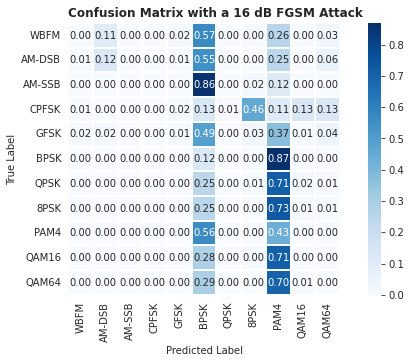

In [ ]:
predictions = list()
labels = list()
for x, y in dl:
    # Before crafting an attack on X, ensure that it is normalized to have a
    # specified power -- RML2016.10a fluctuates a bit, especially on AM-SSB,
    # which will cause the attack intensity to be incorrect.
    x = _normalize(x)
    adv_x = fgsm(x, y, spr=spr, input_size=128, sps=8, net=model)

    # Ensure that we've accurately represented the attack power
    #_sanity_check(desired_spr=spr, adv_x=adv_x, x=x)

    _predictions = model.predict(adv_x)
    predictions.extend(_predictions.detach().numpy())
    labels.extend(y)

cmn = _confusion_matrix(predictions=predictions, labels=labels, le=le)

title = "Confusion Matrix with a {spr} dB FGSM Attack".format(spr=spr)
fig = plot_confusion(cm=cmn, labels=le.labels, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/fgsm_confusion_matrix.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

PGD attack 1 - 1 DB






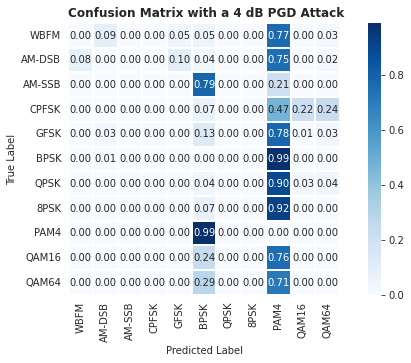

In [ ]:
spr = 4 #signal to perturbation ratio in DB
k = 2

predictions = list()
labels = list()
for x, y in dl:
    # Before crafting an attack on X, ensure that it is normalized to have a
    # specified power -- RML2016.10a fluctuates a bit, especially on AM-SSB,
    # which will cause the attack intensity to be incorrect.
    x = _normalize(x)
    adv_x = pgd(x, y, k=k, spr=spr, input_size=128, sps=sps, net=model)

    # Ensure that we've accurately represented the attack power
    #_sanity_check(desired_spr=spr, adv_x=adv_x, x=x)

    _predictions = model.predict(adv_x)
    predictions.extend(_predictions.detach().numpy())
    labels.extend(y)

cmn = _confusion_matrix(predictions=predictions, labels=labels, le=le)

title = "Confusion Matrix with a {spr} dB PGD Attack".format(spr=spr)
fig = plot_confusion(cm=cmn, labels=le.labels, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/pgd_confusion_matrix.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

PGD attack 2 - 4 DB

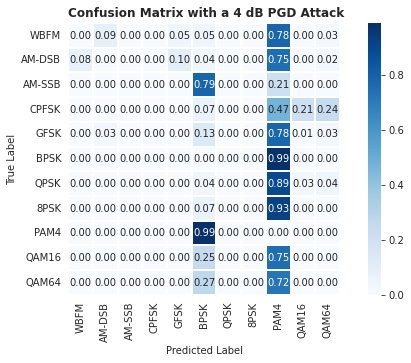

In [ ]:
spr = 4 #signal to perturbation ratio in DB
k = 2

predictions = list()
labels = list()
for x, y in dl:
    # Before crafting an attack on X, ensure that it is normalized to have a
    # specified power -- RML2016.10a fluctuates a bit, especially on AM-SSB,
    # which will cause the attack intensity to be incorrect.
    x = _normalize(x)
    adv_x = pgd(x, y, k=k, spr=spr, input_size=128, sps=sps, net=model)

    # Ensure that we've accurately represented the attack power
    #_sanity_check(desired_spr=spr, adv_x=adv_x, x=x)

    _predictions = model.predict(adv_x)
    predictions.extend(_predictions.detach().numpy())
    labels.extend(y)

cmn = _confusion_matrix(predictions=predictions, labels=labels, le=le)

title = "Confusion Matrix with a {spr} dB PGD Attack".format(spr=spr)
fig = plot_confusion(cm=cmn, labels=le.labels, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/pgd_confusion_matrix.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

PGD attack 3 - 8 DB

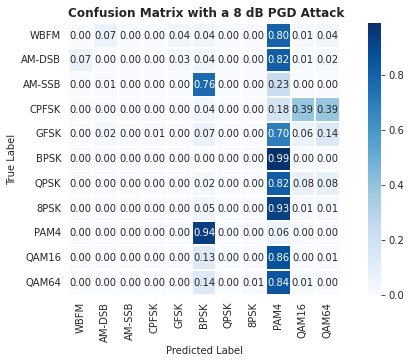

In [ ]:
spr = 8 #signal to perturbation ratio in DB
k = 2

predictions = list()
labels = list()
for x, y in dl:
    # Before crafting an attack on X, ensure that it is normalized to have a
    # specified power -- RML2016.10a fluctuates a bit, especially on AM-SSB,
    # which will cause the attack intensity to be incorrect.
    x = _normalize(x)
    adv_x = pgd(x, y, k=k, spr=spr, input_size=128, sps=sps, net=model)

    # Ensure that we've accurately represented the attack power
    #_sanity_check(desired_spr=spr, adv_x=adv_x, x=x)

    _predictions = model.predict(adv_x)
    predictions.extend(_predictions.detach().numpy())
    labels.extend(y)

cmn = _confusion_matrix(predictions=predictions, labels=labels, le=le)

title = "Confusion Matrix with a {spr} dB PGD Attack".format(spr=spr)
fig = plot_confusion(cm=cmn, labels=le.labels, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/pgd_confusion_matrix.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

PGD attack 4 - 12 DB

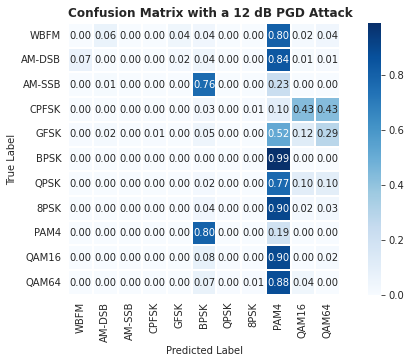

In [ ]:
spr = 12 #signal to perturbation ratio in DB
k = 2

predictions = list()
labels = list()
for x, y in dl:
    # Before crafting an attack on X, ensure that it is normalized to have a
    # specified power -- RML2016.10a fluctuates a bit, especially on AM-SSB,
    # which will cause the attack intensity to be incorrect.
    x = _normalize(x)
    adv_x = pgd(x, y, k=k, spr=spr, input_size=128, sps=sps, net=model)

    # Ensure that we've accurately represented the attack power
    #_sanity_check(desired_spr=spr, adv_x=adv_x, x=x)

    _predictions = model.predict(adv_x)
    predictions.extend(_predictions.detach().numpy())
    labels.extend(y)

cmn = _confusion_matrix(predictions=predictions, labels=labels, le=le)

title = "Confusion Matrix with a {spr} dB PGD Attack".format(spr=spr)
fig = plot_confusion(cm=cmn, labels=le.labels, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/pgd_confusion_matrix.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

PGD attack 4 - 16 DB

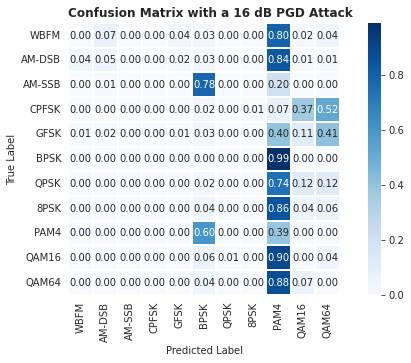

In [ ]:
spr = 16 #signal to perturbation ratio in DB
k = 2

predictions = list()
labels = list()
for x, y in dl:
    # Before crafting an attack on X, ensure that it is normalized to have a
    # specified power -- RML2016.10a fluctuates a bit, especially on AM-SSB,
    # which will cause the attack intensity to be incorrect.
    x = _normalize(x)
    adv_x = pgd(x, y, k=k, spr=spr, input_size=128, sps=sps, net=model)

    # Ensure that we've accurately represented the attack power
    #_sanity_check(desired_spr=spr, adv_x=adv_x, x=x)

    _predictions = model.predict(adv_x)
    predictions.extend(_predictions.detach().numpy())
    labels.extend(y)

cmn = _confusion_matrix(predictions=predictions, labels=labels, le=le)

title = "Confusion Matrix with a {spr} dB PGD Attack".format(spr=spr)
fig = plot_confusion(cm=cmn, labels=le.labels, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/pgd_confusion_matrix.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

Summary

Radio Frequency via AMC with typical CLDNN setup

